# FORESEE - Heavy Neutral Leptons (HNLs)

### Load Libraries 

In [1]:
import numpy as np
import sys
import os
import matplotlib.colors as mcolors
src_path = "../.."
sys.path.append(src_path)
from src.foresee import Foresee, Utility, Model

from HeavyNeutralLepton import * 

from matplotlib import pyplot as plt
import pandas as pd
import os
import glob

from matplotlib import pyplot as plt
import pandas as pd
from os.path import exists

from scipy.integrate import quad

## 1. Initialization 


All function that we will need are included in the FORESEE package. We start by simply initializing it: 

In [2]:
foresee = Foresee()

HNL's are produced mainly via D and $B$ meson decay. To start, let us have a look at the $\text{D}^+$ spectrum in terms of the angle with respect to the beam axis $\theta$ and the momentum $p$. This can be done using the function `get_spectrumplot` which requires the MC particle ID (or simply pid), the MC generator and the energy. The units on the coloraxis are pb/bin. 

FORESEE provides the 2D spectrum as tables for a variety of particles ($\pi$, $\eta$, D, B, ...), generators (SIBYLL, EPOSLHC, QGSJET, PYTHIA) and collision energies (14, 27 and 100 TeV). The datafiles are stored in the directory `files/hadrons`. Let us show the $\text{D}^+$ spectrum obained by Pythia8. 

In [3]:
# plot=foresee.get_spectrumplot(pid="15", generator="pythia8", energy="14",  prange=[[-5, 0, 100],[ 0, 4, 80]])
# plot.show()

## 2. Specifying the Model: Heavy Neutral Leptons

In this notebook we consider Heavy Neutral Leptons (HNLs) $N$. These for example naturally arise in models with an addition right handed neutrinos. Their phenomenology is described by a the folling Lagrangian 

\begin{equation}
 \mathcal{L} = \bar N (i \gamma^\mu \partial_{\mu} - {m_N}) N - (g/\sqrt{2}) {U_{\alpha}} W_\mu \bar \ell_\alpha \gamma^\mu N - (g/\sqrt{2} c_W) {U_{\alpha}} Z_\mu \bar \nu_\alpha \gamma^\mu N 
\end{equation}

where ${m_N}$ is the HNL mass, and ${U_{\alpha}}$ are the mixings of the HNL with the SM neutrinos of flavour $\alpha=e,\mu, \tau$. For practical purposes, we will define ${U_{\alpha}} = {g} \times V_\alpha$ where $V_\alpha$ is fixed. In this case the HNL mass ${m_N}$ and the coupling ${g}$ are the free parameters of the model. 

Since the HNL model is rather complicted, we will use dedicated the `HeavyNeutralLepton` class, which will provide all properties of the model, eg their the *production rate*, the *lifetime* and their *decay branching fractions*. It will be initialized with the values of $V_\alpha$.

In [4]:
hnl = HeavyNeutralLepton(ve=0.1, vmu=0, vtau=0)
nsteps=100


All properties are specified in the `Model` class. We initialize it with the name of the model as argument. 

In [5]:
energy = "14"
modelname="HNL"
model = Model(modelname, path="./")
allchannels = []
production_channels=[]

### a) HNL Production
As most LLPs, HNLs are produced in the decay of primary hadrons. Here we need to specify the total branching fraction into the LLP as function of the `coupling` and the `mass`. 

**Production via 2-body decays** HNLs can be produced in 2-body decays of the type $H^+ \to \ell N$. The corresponding branching fractions are given by  

\begin{equation}
    \text{BR}(H^+ \rightarrow \ell_{\alpha}^{+} N ) =   |U_{\alpha}|^2 \frac{G_F^2 M_H M_N^2 \tau_H f_H^2 |V_H|^2 }{8 \pi}  \cdot \left[ 1- \frac{M_N^2}{M_H^2} + 2 \frac{M_{\ell}^2}{M_H^2}+ \frac{M_{\ell}^2}{M_N^2} \left( 1- \frac{M_{\ell}^2}{M_H^2} \right) \right] \times \left[\left(1+ \frac{M_N^2}{M_H^2}- \frac{M_{\ell}^2}{M_H^2}\right)^2 - 4 \frac{M_N^2}{M_H^2}\right]^{1/2}
\end{equation}

Source: https://cds.cern.ch/record/2133817/files/main.pdf

In particular we consider the decays:
- $D^\pm, D_s^\pm, B^\pm, B_c^\pm \to \ell^\pm N$

In [6]:
#colors for plots
import random
colors=list(mcolors.CSS4_COLORS)


In [7]:
#2 body pseudoscalar meson decays
#elements in channels have the form [decay label, parent particle pid (with sign), sign of produced lepton PID (- for positron + for electron),generator]
channels = [
    [r'D^+ \to l^+ + N'    , '411', '-',"Pythia8"],
    [r'D^- \to l^- + N'    ,'-411', '' ,"Pythia8"],
    [r'D_s^+ \to l^+ + N'  , '431', '-',"Pythia8"],
    [r'D_s^- \to l^- + N'  ,'-431', '' ,"Pythia8"],
    [r'B^+ \to + l^+ + N'  , '521', '-',"Pythia8"],
    [r'B^- \to + l^- + N'  ,'-521', '' ,"Pythia8"],
    [r'B_c^+ \to + l^+ + N', '541', '-',"Pythia8"],
    [r'B_c^- \to + l^- + N','-541', '' ,"Pythia8"],
    [r'pi^+ \to + l^+ + N','211', '-' ,"EPOSLHC"],
    [r'pi^- \to + l^- + N','-211', '' ,"EPOSLHC"],
    [r'K^+ \to + l^+ + N','321', '-' ,"EPOSLHC"],
    [r'K^- \to + l^- + N','-321', '' ,"EPOSLHC"]
]

#temporary to test
channels=[[r'pi^+ \to + l^+ + N','211', '-' ,"EPOSLHC"],
    [r'pi^- \to + l^- + N','-211', '' ,"EPOSLHC"]]

length=len(colors)  #this is used in the for loop below  
for label, pid_had, sign_lep, generator in channels:
    for pid_lep in ["11","13","15"]:
        if hnl.vcoupling[pid_lep] <1e-9: continue
        label1 = "2body_" + pid_had + "_" + sign_lep+pid_lep
        label2='[' + '"' + label1 + '"' + ', ' + '"' + colors[random.randint(0,length-1)] + '"' + ', ' + 'r"$' + label + '$"' + '],'
        production_channels.append(label2)
        print(label2)
        model.add_production_2bodydecay(
            label = label1,
            pid0 = pid_had,
            pid1 = pid_lep,
            br = hnl.get_2body_br(pid_had, sign_lep+pid_lep),
            generator = generator,
            energy = energy,
            nsample = nsteps,
        )
        allchannels.append(label1)


["2body_211_-11", "cyan", r"$pi^+ \to + l^+ + N$"],
["2body_-211_11", "lightyellow", r"$pi^- \to + l^- + N$"],


**Production via 2-body $\tau$ decays** HNLs can be produced in 2-body decays of the type $\tau \to H N$, the corresponding branching fraction is given by

\begin{aligned}
    \mathrm{Br}(\tau \rightarrow \mathrm{HN}) &=\tau_\tau \cdot \frac{\left|U_\tau\right|^2}{16 \pi} G_F^2\left|V_H\right|^2 f_H^2 M_\tau^3 \cdot\left(\left(1-\frac{M_N^2}{M_\tau^2}\right)^2-\frac{M_H^2}{M_\tau^2}\left(1+\frac{M_N^2}{M_\tau^2}\right)\right) \\
    & \times \sqrt{\left(1-\frac{\left(M_H-M_N\right)^2}{M_\tau^2}\right)\left(1-\frac{\left(M_H+M_N\right)^2}{M_\tau^2}\right)}
\end{aligned}

or of the form $\tau \to \rho N$, in this case the branching fraction is given by

\begin{aligned}
    \mathrm{Br}(\tau \rightarrow \rho \mathrm{N}) &=\tau_\tau \cdot \frac{\left|U_\tau\right|^2}{8 \pi} \frac{g_\rho^2}{M_\rho^2} G_F^2\left|V_{u d}\right|^2 M_\tau^3 \cdot\left(\left(1-\frac{M_N^2}{M_\tau^2}\right)^2+\frac{M_\rho^2}{M_\tau^2}\left(1+\frac{M_N^2-2 M_\rho^2}{M_\tau^2}\right)\right) \\
    & \times \sqrt{\left(1-\frac{\left(M_\rho-M_N\right)^2}{M_\tau^2}\right)\left(1-\frac{\left(M_\rho+M_N\right)^2}{M_\tau^2}\right)}
\end{aligned}

Source: https://cds.cern.ch/record/2133817/files/main.pdf

In particular we consider the decays:
- $\tau^{\pm} \to \pi^{\pm},K^{\pm}, \rho^{\pm} N$

In [8]:
#tau 2 body decays
#elements in channels have the form [decay label, parent particle pid, produced hadron pid (without sign), sign of produced hadron, generator]
channels = [
[r'\tau^- \to \pi^- + N','15','211', '-' , "Pythia8"],
[r'\tau^+ \to \pi^+ + N','-15','211', ''  , "Pythia8"],
[r'\tau^- \to K^- + N'  ,'15','321', '-' , "Pythia8"],
[r'\tau^+ \to K^+ + N'  ,'-15','321', ''  , "Pythia8"],
[r'\tau^- \to \rho^- + N','15','213', '-', "Pythia8"],
[r'\tau^+ \to \rho^+ + N','-15','213', '' , "Pythia8"]
]

#temporary
channels=[[r'\tau^- \to \rho^- + N','15','213', '-', "Pythia8"],
[r'\tau^+ \to \rho^+ + N','-15','213', '' , "Pythia8"]]

length=len(colors)
for label, pid_tau, pid_had, sign_had, generator in channels:
    for pid_tau in ['15','-15']:
        if hnl.vcoupling[str(abs(int(pid_tau)))] <1e-9: continue
        label1 = "2body_tau_" + pid_tau + "_" + sign_had+pid_had
        label2='[' + '"' + label1 + '"' + ', ' + '"' + colors[random.randint(0,length-1)] + '"' + ', ' + 'r"$' + label + '$"' + '],'
        production_channels.append(label2)
        print(label2)
        model.add_production_2bodydecay(
            label = label1,
            pid0 = pid_tau,
            pid1 = pid_had,
            br = hnl.get_2body_br_tau(pid_tau, sign_had+pid_had),
            generator = generator,
            energy = energy,
            nsample = nsteps,
        )
        allchannels.append(label1)

**Production via 3-body decay to pseudoscalar meson** HNLs can also be produced in 3-body decays of the type $H \to H' \ell N$, where H' is a pseudoscalar. The corresponding branching fractions are given by  

\begin{aligned}
&\frac{d \mathrm{Br}\left(\mathrm{H} \rightarrow \mathrm{H}^{\prime} \mathrm{l}_\alpha^{+} \mathrm{N}\right)}{d E_N d q^2}=\tau_H \cdot\left|U_\alpha\right|^2 \cdot \frac{\left|V_{H H^{\prime}}\right|^2 G_F^2}{64 \pi^3 M_H^2} \left(f_{-}^2\left(q^2\right) \cdot\left(q^2\left(M_N^2+M_l^2\right)-\left(M_N^2-M_l^2\right)^2\right)\right. \\
&+2 f_{+}\left(q^2\right) f_{-}\left(q^2\right)\left(M_N^2\left(2 M_H^2-2 M_{H^{\prime}}^2-4 E_N M_H-M_l^2+M_N^2+q^2\right)+M_l^2\left(4 E_N M_H+M_l^2-M_N^2-q^2\right)\right) \\
& +f_{+}^2\left(q^2\right)\left(\left(4 E_N M_H+M_l^2-M_N^2-q^2\right)\left(2 M_H^2-2 M_{H^{\prime}}^2-4 E_N M_H-M_l^2+M_N^2+q^2\right)\right. \\
&\left.-\left(2 M_H^2+2 M_{H^{\prime}}^2-q^2\right)\left(q^2-M_N^2-M_l^2\right)\right)
\end{aligned}

where

\begin{aligned}
f_{+}\left(q^2\right) &=\frac{f_{+}(0)}{\left(1-q^2 / M_V^2\right)} \\
f_0\left(q^2\right) &=\frac{f_0(0)}{\left(1-q^2 / M_S^2\right)} \\
f_0\left(q^2\right)=f_{+}\left(q^2\right) &+\frac{q^2}{M_H^2-M_{H'}^2} f_{-}\left(q^2\right).
\end{aligned}

Source: https://cds.cern.ch/record/2133817/files/main.pdf

- For $D \rightarrow H' + \ell + \nu$ decays, $M_V$ and $M_S$ are the vector and scalar pole masses and are given by the $D^*(2010)$ and $D_0^*(2400)$ masses, respectively. $f_0(0)$ is obtained from https://arxiv.org/pdf/1511.04877.pdf (Note $f_0(0)=f_+(0)$ and $f_-(0)$ can be obtained from these)
- For $B \rightarrow D + \ell + \nu$ decays, $M_V$ and $M_S$ are the vector and scalar pole masses and are given by the $B^*_c$ and $B_c$ masses (as suggested in https://journals.aps.org/prd/pdf/10.1103/PhysRevD.62.014006), respectively. $f_0(0)$ is obtained from https://arxiv.org/pdf/1505.03925v2.pdf
- For $B_s \rightarrow D_s + \ell + \nu$ decays, $M_V$ and $M_S$ are the vector and scalar pole masses and are given by the $B^*$ and $B$ masses (as suggested in https://journals.aps.org/prd/pdf/10.1103/PhysRevD.62.014006), respectively. $f_0(0)$ is obtained from https://arxiv.org/pdf/1106.3003.pdf (table 1)
- For $B_c \rightarrow B^0 + \ell + \nu$ or $B_c \rightarrow B_s^0 + \ell + \nu$ decays, $M_V$ and $M_S$ are the vector and scalar pole masses and are given by the $B^*_c$ and $B_c$ masses, respectively. $f_0(0)$ is obtained from https://arxiv.org/pdf/hep-ph/0007169.pdf (table 2)


To obtain the branching fraction we use integration bounds
$$(m_{\ell} + m_N)^2 \leq q^2 \leq (m_H - m_{H'})^2$$ 
with 
$$q^2=m_{H \ell}^2$$
and
$$E_N({m_{\ell N}^2}^{\text{min}}) \leq E_N \leq E_N({m_{\ell N}^2}^{\text{max}})$$
where 
$$E_N = \frac{m_{\ell N}^2 + q^2 - m_{\ell}^2 - m_{H'}^2}{2m_{H}}$$
${m_{\ell N}^2}^{\text{min}}$ and ${m_{\ell N}^2}^{\text{max}}$ are as given in https://pdg.lbl.gov/2019/reviews/rpp2019-rev-kinematics.pdf 

(we use the convention $H \sim 0$, $H' \sim 1$, $\ell \sim 2$, and $N \sim 3$; e.g. $m_{23}^2=m_{\ell N}^2$)

In particular we consider the decays:
- $D^0 \to K^{\mp} \ell^{\pm} N, \text{ where } \ell \neq \tau$ (since $D^0$ is not heavy enough)
- $D^{\pm} \to \bar{K^0}  \ell^{\pm} N, \text{ where } \ell \neq \tau$
- $B^{\pm} \to \bar{D^0} \ell^{\pm} N, \text{ including } \tau$
- $B^0 \to D^{\mp} \ell^{\pm} N, \text{ including } \tau$
- $B_s^0 \to D_s^{\mp} \ell^{\pm} N, \text{ including } \tau$
- $B_c^{\pm} \to B^0 \ell^{\pm} N, \text{ where } \ell \neq \tau$
- $B_c^{\pm} \to B_s^0 \ell^{\pm} N, \text{ where } \ell \neq \tau$ 

In [9]:
#3 body decay into pseudoscalar mesons
#elements of 'channels' have the form [decay label, pid of parent hadron, pid of daughter meson (with sign!), sign of produced lepton's pid]
channels = [
    [r'D^0 \to K^- + l^+ + N'             , '421', '-321', '-', "Pythia8"],
    [r'D^0 \to K^+ + l^- + N'             , '-421', '321', '' , "Pythia8" ],
    [r'D^+ \to K^0 + l^+ + N'              , '411', '311', '-', "Pythia8"],
    [r'D^- \to \bar{K}^0 + l^- + N'        ,'-411', '-311' , '' , "Pythia8"],
    [r'B^+ \to D^0 + l^+ + N'              , '521',  '421', '-', "Pythia8"],
    [r'B^- \to \bar{D}^0 + l^- + N'        , '-521',  '-421' , '', "Pythia8"],
    [r'B^0 \to D^- + l^+ + N'             , '511', '-411', '-', "Pythia8"],
    [r'B^0 \to D^+ + l^- + N'             , '-511', '411', ''  , "Pythia8"],
    [r'B^0_s \to D^-_s + l^+ + N'         , '531', '-431', '-', "Pythia8"],
    [r'B^0_s \to D^+_s + l^- + N'         , '-531', '431', ''  , "Pythia8"],
    [r'B^+_c \to B^0 + l^+ + N'           , '541',  '511', '-', "Pythia8"],
    [r'B^-_c \to \bar{B}^0 + l^- + N'     , '-541',  '-511', '', "Pythia8"],
    [r'B^+_c \to B^0_s + l^+ + N'         , '541',  '531', '-', "Pythia8"],
    [r'B^-_c \to \bar{B}^0_s + l^- + N'   , '-541',  '-531', '', "Pythia8"]

]

#temporary to test
channels=[    [r'B^+_c \to B^0 + l^+ + N'           , '541',  '511', '-', "Pythia8"],[r'B^-_c \to \bar{B}^0 + l^- + N'     , '-541',  '-511', '', "Pythia8"],[r'B^+_c \to B^0_s + l^+ + N'         , '541',  '531', '-', "Pythia8"],
    [r'B^-_c \to \bar{B}^0_s + l^- + N'   , '-541',  '-531', '', "Pythia8"]]


length=len(colors)
for label, pid_parent, pid_daughter, sign_lep, generator in channels:
    if model.masses(pid_parent) >= model.masses('15') + model.masses(pid_daughter):
        leptons=["11","13","15"]
    if model.masses(pid_parent) <= model.masses('15') + model.masses(pid_daughter):
        leptons=["11","13"]
    for pid_lep in leptons:
        if hnl.vcoupling[pid_lep] <1e-9: continue
        label1="3body_pseudo_" + pid_parent + "_" +pid_daughter+ "_" + sign_lep+pid_lep
        label2='[' + '"' + label1 + '"' + ', ' + '"' + colors[random.randint(0,length-1)] + '"' + ', ' + 'r"$' + label + '$"' + '],'
        production_channels.append(label2)
        print(label2)
        #print('[' + '"' + label1 + '"' + ', ' + '"' + colors[random.randint(0,length-1)] + '"' + ', ' + 'r"$' + label + '$"' + '],')
        model.add_production_3bodydecay(
            label = label1,
            pid0 = pid_parent,
            pid1 = pid_daughter,
            pid2 = sign_lep+pid_lep,
            br = hnl.get_3body_dbr_pseudoscalar(pid_parent,pid_daughter,sign_lep+pid_lep),
            generator = generator,
            energy = energy,
            nsample = nsteps,
            integration = "dq2dEN",
        )
        allchannels.append(label1)

["3body_pseudo_541_511_-11", "lightyellow", r"$B^+_c \to B^0 + l^+ + N$"],
["3body_pseudo_-541_-511_11", "lemonchiffon", r"$B^-_c \to \bar{B}^0 + l^- + N$"],
["3body_pseudo_541_531_-11", "cornflowerblue", r"$B^+_c \to B^0_s + l^+ + N$"],
["3body_pseudo_-541_-531_11", "navy", r"$B^-_c \to \bar{B}^0_s + l^- + N$"],


**Production via 3-body decay to vector meson** HNLs can also be produced in 3-body decays of the type $H \to V \ell N$, where V is a vector. The corresponding differential branching fractions are given by 
\begin{aligned}
\frac{d \operatorname{Br}\left(H \rightarrow V l_\alpha N\right)}{d E_N d q^2}=\tau_H \cdot\left|U_\alpha\right|^2 \cdot \frac{\left|V_{H V}\right|^2 G_F^2}{32 \pi^3 M_H} \left(\frac{f_2^2}{2}\left(q^2-M_N^2-M_l^2+\omega^2 \frac{\Omega^2-\omega^2}{M_V^2}\right)\right. \\
+\frac{f_5^2}{2}\left(M_N^2+M_l^2\right)\left(q^2-M_N^2+M_l^2\right)\left(\frac{\Omega^4}{4 M_V^2}-q^2\right)+2 f_3^2 M_V^2\left(\frac{\Omega^4}{4 M_V^2}-q^2\right)\left(M_N^2+M_l^2-q^2+\omega^2 \frac{\Omega^2-\omega^2}{M_V^2}\right) \\
+2 f_3 f_5\left(M_N^2 \omega^2+\left(\Omega^2-\omega^2\right) M_l^2\right)\left(\frac{\Omega^4}{4 M_V^2}-q^2\right)+2 f_1 f_2\left(q^2\left(2 \omega^2-\Omega^2\right)+\Omega^2\left(M_N^2-M_l^2\right)\right) \\
+\frac{f_2 f_5}{2}\left(\omega^2 \frac{\Omega^2}{M_V^2}\left(M_N^2-M_l^2\right)+\frac{\Omega^4}{M_V^2} M_l^2+2\left(M_N^2-M_l^2\right)^2-2 q^2\left(M_N^2+M_l^2\right)\right) \\
+f_2 f_3\left(\Omega^2 \omega^2 \frac{\Omega^2-\omega^2}{M_V^2}+2 \omega^2\left(M_l^2-M_N^2\right)+\Omega^2\left(M_N^2-M_l^2-q^2\right)\right) \\
\left.+f_1^2\left(\Omega^4\left(q^2-M_N^2+M_l^2\right)-2 M_V^2\left(q^4-\left(M_N^2-M_l^2\right)^2\right)+2 \omega^2 \Omega^2\left(M_N^2-q^2-M_l^2\right)+2 \omega^4 q^2\right)\right) \\
\end{aligned}
where $\omega^2=M_H^2-M_V^2+M_N^2-M_l^2-2 M_H E_N$ and $\Omega^2=M_H^2-M_V^2-q^2.\\$
The form factors are given by

\begin{aligned}
f_1=\frac{V}{M_H+M_V}, \quad f_2=\left(M_H+M_V\right) \cdot A_1, \quad f_3=-\frac{A_2}{M_H+M_V}, \\
f_4=\left(M_V\left(2 A_0-A_1-A_2\right)+M_H\left(A_2-A_1\right)\right) \cdot \frac{1}{q^2}, \quad f_5=f_3+f_4,
\end{aligned}

$$
f\left(q^2\right)=\frac{f(0)}{\left(1-q^2 / M^2\right)\left(1-\sigma_1 q^2 / M^2+\sigma_2 q^4 / M^4\right)}
$$
$M=M_P$ for form factor $A_0$ and $M=M_V$ for form factor $V$. For form factors $A_1$ and $A_2$ :
$$
f\left(q^2\right)=\frac{f(0)}{\left(1-\sigma_1 q^2 / M_V^2+\sigma_2 q^4 / M_V^4\right)}
$$

Source: https://cds.cern.ch/record/2133817/files/main.pdf

In particular we consider the decays:

- $D^0  \to K^{* \mp} \ell^{\pm} N, \text{ where } \ell \neq \tau$ (fit parameters obtained from https://journals.aps.org/prd/pdf/10.1103/PhysRevD.62.014006 (table IV))
- $B^{\pm} \to \bar{D^{*0}} \ell^{\pm} N, \text{ including } \tau$ (fit parameters obtained from https://journals.aps.org/prd/pdf/10.1103/PhysRevD.62.014006 (table X))
- $B^0 \to D^{* \mp} \ell^{\pm} N, \text{ including } \tau$ (fit parameters obtained from https://journals.aps.org/prd/pdf/10.1103/PhysRevD.62.014006 (table X))
- $B^0_s \to D_s^{* \mp} \ell^{\pm} N, \text{ including } \tau$ (fit parameters obtained from https://arxiv.org/pdf/1212.3167.pdf (Table 1))
- $B^{\pm}_c \to B^{*0} \ell^{\pm} N, \text{ where } \ell \neq \tau$ (fit parameters obtained from https://arxiv.org/pdf/hep-ph/0007169.pdf (Table 3))
- $B_c^{\pm} \to B_s^{* 0} \ell^{\pm} N, \text{ where } \ell \neq \tau$ (fit parameters obtained from https://arxiv.org/pdf/hep-ph/0007169.pdf (Table 3))



In [10]:
#vector decays
#elements of channel have the form [decay label, parent pid, daughter pid, sign of produced lepton - (pid) is a positive lepton]
channels = [
[r'D^0 \to K^{*-} + l^+ + N'                  ,'421', '-323', '-',"Pythia8"],
[r'D^0 \to K^{*+} + l^- + N'             ,'-421', '323', ''   ,"Pythia8"],
[r'B^+ \to D^*0 + l^+ + N'                    ,'521','423' , '-'  ,"Pythia8"],
[r'B^- \to \bar{D}^*0 + l^- + N'              ,'-521','-423' , ''  ,"Pythia8"],
[r'B^0 \to D^{*-} + l^+ + N'                  ,'511','-413' , '-',"Pythia8"],
[r'B^0 \to D^{*+} + l^- + N'            ,'-511','413' , ''  ,"Pythia8"],
[r'B^0_s \to D^{*-}_s + l^+ + N'              ,'531','-433' , '-' ,"Pythia8"],
[r'B^0_s \to D^{*+}_s + l^- + N'        ,'-531','433' , ''   ,"Pythia8"],
[r'B^+_c \to B^{*0} + l^+ + N'                ,'541','513'  , '-',"Pythia8"],
[r'B^-_c \to \bar{B}^{*0} + l^- + N'          ,'-541','-513'  , '',"Pythia8"],
[r'B^+_c \to B^{*0}_s+ l^+ + N'               ,'541','533'  , '-' ,"Pythia8"],
[r'B^-_c \to \bar{B}^{*0}_s+ l^- + N'         ,'-541','-533'  , '' ,"Pythia8"]
]

#temporary for test
channels=[[r'D^0 \to K^{*-} + l^+ + N'                  ,'421', '-323', '-',"Pythia8"],
[r'D^0 \to K^{*+} + l^- + N'             ,'-421', '323', ''   ,"Pythia8"],[r'B^+_c \to B^{*0} + l^+ + N'                ,'541','513'  , '-',"Pythia8"],
[r'B^-_c \to \bar{B}^{*0} + l^- + N'          ,'-541','-513'  , '',"Pythia8"],[r'B^+_c \to B^{*0}_s+ l^+ + N'               ,'541','533'  , '-' ,"Pythia8"],
[r'B^-_c \to \bar{B}^{*0}_s+ l^- + N'         ,'-541','-533'  , '' ,"Pythia8"]]

length=len(colors)
for label, pid_parent, pid_daughter, sign_lep, generator in channels:
    if model.masses(pid_parent) >= model.masses('15') + model.masses(pid_daughter):
        leptons=["11","13","15"]
    if model.masses(pid_parent) <= model.masses('15') + model.masses(pid_daughter):
        leptons=["11","13"]
    for pid_lep in ["11","13","15"]:
        if hnl.vcoupling[pid_lep] <1e-9: continue
        label1="3body_vector_" + pid_parent + "_" +pid_daughter+ "_" + sign_lep+pid_lep
        label2='[' + '"' + label1 + '"' + ', ' + '"' + colors[random.randint(0,length-1)] + '"' + ', ' + 'r"$' + label + '$"' + '],'
        production_channels.append(label2)
        print(label2)
        #print('[' + '"' + label1 + '"' + ', ' + '"' + colors[random.randint(0,length-1)] + '"' + ', ' + 'r"$' + label + '$"' + '],')
        model.add_production_3bodydecay(
            label = label1,
            pid0 = pid_parent,
            pid1 = pid_daughter,
            pid2 = sign_lep+pid_lep,
            br = hnl.get_3body_dbr_vector(pid_parent,pid_daughter,sign_lep+pid_lep),
            generator = generator,
            energy = energy,
            nsample = nsteps,
            integration = "dq2dEN",
        )
        allchannels.append(label1)


["3body_vector_421_-323_-11", "cadetblue", r"$D^0 \to K^{*-} + l^+ + N$"],
["3body_vector_-421_323_11", "darkkhaki", r"$D^0 \to K^{*+} + l^- + N$"],
["3body_vector_541_513_-11", "blueviolet", r"$B^+_c \to B^{*0} + l^+ + N$"],
["3body_vector_-541_-513_11", "tomato", r"$B^-_c \to \bar{B}^{*0} + l^- + N$"],
["3body_vector_541_533_-11", "goldenrod", r"$B^+_c \to B^{*0}_s+ l^+ + N$"],
["3body_vector_-541_-533_11", "slategrey", r"$B^-_c \to \bar{B}^{*0}_s+ l^- + N$"],


**Production via 3-body $\tau$ decay** HNLs can also be produced in 3-body decays of $\tau$. These decays are of the type $\tau \to \nu_{\tau} \ell_{\alpha} N$ or $\tau \to \bar{\nu}_{\alpha} \ell_{\alpha} N$. The corresponding differential branching fractions are given by,
\begin{aligned}
\frac{d \mathrm{Br}\left(\tau \rightarrow \nu_\tau \mathrm{l}_\alpha \mathrm{N}\right)}{d E_N} &=\tau_\tau \cdot \frac{\left|U_\alpha\right|^2}{2 \pi^3} G_F^2 M_\tau^2 \cdot E_N\left(1+\frac{M_N^2-M_l^2}{M_\tau^2}-2 \frac{E_N}{M_\tau}\right)\left(1-\frac{M_l^2}{M_\tau^2+M_N^2-2 E_N M_\tau}\right) \sqrt{E_N^2-M_N^2} \\
\end{aligned}
and
\begin{aligned}
\frac{d \operatorname{Br}\left(\tau \rightarrow \bar{\nu}_\alpha l_\alpha \mathrm{N}\right)}{d E_N} &=\tau_\tau \cdot \frac{\left|U_\tau\right|^2}{4 \pi^3} G_F^2 M_\tau^2\left(1-\frac{M_l^2}{M_\tau^2+M_N^2-2 E_N M_\tau}\right)^2 \sqrt{E_N^2-M_N^2} \\
& \times\left(\left(M_\tau-E_N\right)\left(1-\frac{M_N^2+M_l^2}{M_\tau^2}\right)-\left(1-\frac{M_l^2}{M_\tau^2+M_N^2-2 E_N M_\tau}\right)\left(\frac{\left(M_\tau-E_N\right)^2}{M_\tau}+\frac{E_N^2-M_N^2}{3 M_\tau}\right)\right)
\end{aligned}

Source: https://cds.cern.ch/record/2133817/files/main.pdf

The bounds of integration are given by

$m_N \leq E_N \leq \frac{m_H^2 + m_N^2 -(m_{H'}+m_H)^2}{2 m_H}$

In particular we consider the decays:
- $\tau^{\pm} \to \nu_{\tau} \ell^{\pm}_{\alpha} N, \text{ where } \alpha \neq \tau$
- $\tau^{\pm} \to \bar{\nu}_{\alpha} \ell_{\alpha}^{\pm} N, \text{ where } \alpha \neq \tau$


In [11]:
#tau 3 body decays \tau \to \nu_{\tau} + l_{\alpha} + N
channels = [
[r'\tau^- \to l^- + \nu_{\tau} + N','15','16','',"Pythia"],
[r'\tau^+ \to l^+ + \nu_{\tau} + N','-15','-16','-',"Pythia"]
]

for label, pid_parent, pid_nu, sign_lep, generator in channels:
    for pid_lep in ["11","13"]:
        if hnl.vcoupling[pid_lep] <1e-9: continue
        label1="3body_tau_" + pid_parent + "_" + sign_lep+pid_lep + "_" + pid_nu
        label2='[' + '"' + label1 + '"' + ', ' + '"' + colors[random.randint(0,length-1)] + '"' + ', ' + 'r"$' + label + '$"' + '],'
        production_channels.append(label2)
        print(label2)
        #print('[' + '"' + label1 + '"' + ', ' + '"' + colors[random.randint(0,length-1)] + '"' + ', ' + 'r"$' + label + '$"' + '],')
        model.add_production_3bodydecay(
            label = label1,
            pid0 = pid_parent,
            pid1 = sign_lep+pid_lep,
            pid2 = pid_nu,
            br = hnl.get_3body_dbr_tau(pid_parent,sign_lep+pid_lep,pid_nu),
            generator = generator,
            energy = energy,
            nsample = nsteps,
            integration = "dEN",
        )
        allchannels.append(label1)


#tau 3 body decays '\tau^- \to l^- + \bar{\nu}_l + N'
channels=[
[r'\tau^- \to l^- + \bar{\nu}_l + N','15','',"Pythia"],
[r'\tau^+ \to l^+ + \bar{\nu}_l + N','-15','-',"Pythia"]
]
pid_tau="15"
for label, pid_parent, sign_lep, generator in channels:
    for pid_lep in ["11","13"]:
        if pid_lep=="11":
            pid_nu="12"
        if pid_lep=="13":
            pid_nu="14"
        if sign_lep + pid_lep=="-11":
            pid_nu="-12"
        if sign_lep + pid_lep=="-13":
            pid_nu="-14"
        if hnl.vcoupling[pid_tau] <1e-9: continue
        label1="3body_tau_" + pid_parent + "_" + sign_lep+pid_lep + "_" + pid_nu
        label2='[' + '"' + label1 + '"' + ', ' + '"' + colors[random.randint(0,length-1)] + '"' + ', ' + 'r"$' + label + '$"' + '],'
        production_channels.append(label2)
        print(label2)
        #print('[' + '"' + label1 + '"' + ', ' + '"' + colors[random.randint(0,length-1)] + '"' + ', ' + 'r"$' + label + '$"' + '],')
        model.add_production_3bodydecay(
            label = label1,
            pid0 = pid_parent,
            pid1 = sign_lep+pid_lep,
            pid2 = pid_nu,
            br = hnl.get_3body_dbr_tau(pid_parent,sign_lep+pid_lep,pid_nu),
            generator = generator,
            energy = energy,
            nsample = nsteps,
            integration = "dEN",
        )
        allchannels.append(label1)







["3body_tau_15_11_16", "floralwhite", r"$\tau^- \to l^- + \nu_{\tau} + N$"],
["3body_tau_-15_-11_-16", "gray", r"$\tau^+ \to l^+ + \nu_{\tau} + N$"],


### b) HNL Decays

HNLs can decay in a variety of final states, where the BR and lifetimes depend on our choice of $V_\alpha$. Their branching fractions for the leptonic decay modes are given by,

**Decay via 3-body leptonic decays**

$\Gamma\left(N \rightarrow l_1^{-} l_2^{+} \nu_{l_2}\right)=\left|U_{l_1 N}\right|^2 \frac{G_F^2}{192 \pi^3} m_N^5 I_1\left(y_{l_1}, y_{\nu_{l_2}}, y_{l_2}\right)\left(1-\delta_{l_1 l_2}\right)$

$\Gamma\left(N \rightarrow \nu_{l_1} l_2^{-} l_2^{+}\right)=\left|U_{l_1 N}\right|^2 \frac{G_F^2}{96 \pi^3} m_N^5\left[\left(g_L^l g_R^l+\delta_{l_1 l_2} g_R^l\right) I_2\left(y_{\nu_{l_1}}, y_{l_2}, y_{l_2}\right)\right.
\left.+\left(\left(g_L^l\right)^2+\left(g_R^l\right)^2+\delta_{l_1 l_2}\left(1+2 g_L^l\right)\right) I_1\left(y_{\nu_{l_1}}, y_{l_2}, y_{l_2}\right)\right] $

$\sum_{l_2=e, \mu, \tau} \Gamma\left(N \rightarrow \nu_{l_1} \nu_{l_2} \bar{\nu}_{l_2}\right)=\left|U_{l_1 N}\right|^2 \frac{G_F^2}{96 \pi^3} m_N^5 $

Source: https://arxiv.org/pdf/1005.1607.pdf



For decays into hadrons, below $m_N \approx 3$ GeV it is more accurate to describe HNL decays into bounded hadron states (exclusive), whereas for $m_N>3$ GeV it is more accurate to describe HNL decays into free quarks (inclusive). For the total decay width, only the exclusive modes are considered for $m_N<3$ GeV and for $m_N>3$ GeV only the inclusive modes are considered.

**Decay via 2-body exclusive modes**

$  \Gamma\left(N \rightarrow l_1^{-} P^{+}\right)=\left|U_{l_1 N}\right|^2 \frac{G_F^2}{16 \pi} m_N^3 f_P^2\left|V_P\right|^2 F_P\left(y_{l_1}, y_P\right) $
- The decays $N \rightarrow l_1^{-} \,\,(K^{+}, \pi^+, D^+, D^+_s, B^+, B_c^+)$ are implemented (separately)

$ \Gamma\left(N \rightarrow \nu_{l_1} P^0\right)=\left|U_{l_1 N}\right|^2 \frac{G_F^2}{64 \pi} m_N^3 f_P^2\left(1-y_P^2\right)^2$
- The decays $N \rightarrow \nu_{l_1} \,\, (K^0, \eta, \eta', \pi^0, D^0, B^0, B^0_s)$ are implemented

$\Gamma\left(N \rightarrow l_1^{-} V^{+}\right)=\left|U_{l_1 N}\right|^2 \frac{G_F^2}{16 \pi} m_N^3 f_V^2\left|V_V\right|^2 F_V\left(y_{l_1}, y_V\right) $
- The decays $N \rightarrow l_1^{-} \,\, (K^{* +}, \rho^+, D^{*+}, D^{*+}_s, B^{*+})$ are implemented

$\Gamma\left(N \rightarrow \nu_{l_1} V^0\right)=\left|U_{l_1 N}\right|^2 \frac{G_F^2}{2 \pi} m_N^3 f_V^2 \kappa_V^2\left(1-y_V^2\right)^2\left(1+2 y_V^2\right)$
- The decays $N \rightarrow \nu_{l_1} \,\, (K^{*0}, \omega, \rho^0, \phi, J/\psi, D^{*0})$ are implemented

**Decay via 2-body inclusive modes**

$\Gamma\left(N \rightarrow l_1^{-} u \bar{d}\right)=\left|U_{l_1 N}\right|^2\left|V_{u d}\right|^2 \frac{G_F^2}{64 \pi^3} m_N^5 I_1\left(y_{l_1}, y_u, y_d\right)$
- Neglecting the top quark as it is too heavy

$\Gamma\left(N \rightarrow \nu_{l_1} q \bar{q}\right)=\left|U_{l_1 N}\right|^2 \frac{G_F^2}{32 \pi^3} m_N^5 \left[g_L^q g_R^q I_2\left(y_{\nu_{l_1}}, y_q, y_q\right)+ \left(\left(g_L^q\right)^2+\left(g_R^q\right)^2\right) I_1\left(y_{\nu_{l_1}}, y_q, y_q\right) \right] $
- Neglecting the top quark as it is too heavy

Source: https://arxiv.org/pdf/1005.1607.pdf



**Auxiliary Functions**
The neutral-current couplings for leptons and quarks is given by
$$
\begin{array}{lll}
g_L^l=-1 / 2+\sin ^2 \theta_W, & g_L^u=1 / 2-(2 / 3) \sin ^2 \theta_W, & g_L^d=-1 / 2+(1 / 3) \sin ^2 \theta_W \\
g_R^l=\sin ^2 \theta_W, & g_R^u=-(2 / 3) \sin ^2 \theta_W, & g_R^d=(1 / 3) \sin ^2 \theta_W
\end{array}
$$
The neutral-current couplings for mesons are given by
$$
\begin{array}{ll}
\kappa_V=\sin ^2 \theta_W / 3 & \text { for } \rho^0, \omega, \\
\kappa_V=-1 / 4+\sin ^2 \theta_W / 3 & \text { for } K^{* 0}, \bar{K}^{* 0}, \phi, \\
\kappa_V=1 / 4-2 \sin ^2 \theta_W / 3 & \text { for } D^{* 0}, \bar{D}^{* 0}, J / \psi
\end{array}
$$
The kinematical functions are
$$
\begin{aligned}
&I_1(x, y, z)=12 \int_{(x+y)^2}^{(1-z)^2} \frac{d s}{s}\left(s-x^2-y^2\right)\left(1+z^2-s\right) \lambda^{1 / 2}\left(s, x^2, y^2\right) \lambda^{1 / 2}\left(1, s, z^2\right), \\
&I_2(x, y, z)=24 y z \int_{(y+z)^2}^{(1-x)^2} \frac{d s}{s}\left(1+x^2-s\right) \lambda^{1 / 2}\left(s, y^2, z^2\right) \lambda^{1 / 2}\left(1, s, x^2\right), \\
&F_P(x, y)=\lambda^{1 / 2}\left(1, x^2, y^2\right)\left[\left(1+x^2\right)\left(1+x^2-y^2\right)-4 x^2\right], \\
&F_V(x, y)=\lambda^{1 / 2}\left(1, x^2, y^2\right)\left[\left(1-x^2\right)^2+\left(1+x^2\right) y^2-2 y^4\right],
\end{aligned}
$$

$\begin{aligned} \Gamma_N &=\sum_{l_1, l_2, \mathcal{H}}\left[\eta_N \Gamma\left(N \rightarrow l_1^{-} \mathcal{H}^{+}\right)+\eta_N \Gamma\left(N \rightarrow l_1^{-} l_2^{+} \nu_{l_2}\right) +\Gamma\left(N \rightarrow \nu_{l_1} \mathcal{H}{ }^0\right)+\Gamma\left(N \rightarrow l_2^{-} l_2^{+} \nu_{l_1}\right)+\Gamma\left(N \rightarrow \nu_{l_1} \nu_{l_2} \bar{\nu}_{l_2}\right)\right], \end{aligned}$

For Majorana HNL's $\eta_N=2$ and for Dirac HNL's $\eta_N=1$. Here we only consider Majorana HNL's.

Source: https://arxiv.org/pdf/1005.1607.pdf

In the follwing, we use the function `hnl.get_br_and_ctau()` to create the model files for the branching ratios (stored in /model/br) and lifetime (ctau.txt). 

In [12]:
hnl.get_br_and_ctau(mpts=np.linspace(0.01,10,100))

/Users/laroccod/GITHUB/FORESEE/Models/HNL/HNL_Decay.py:80: RuntimeWarning: invalid value encountered in sqrt
  integrand = lambda s: (1/s) * (1 + x**2 - s)* np.sqrt(Lambda(s,y**2,z**2)) * np.sqrt(Lambda(1,s,x**2))
/Users/laroccod/GITHUB/FORESEE/Models/HNL/HNL_Decay.py:82: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  integral,error = integrate.quad(integrand,(y+z)**2,(1-x)**2)
/Users/laroccod/GITHUB/FORESEE/Models/HNL/HNL_Decay.py:72: RuntimeWarning: invalid value encountered in sqrt
  integrand = lambda s: (1/s) * (s - x**2 - y**2) * (1 + z**2 - s)* np.sqrt(Lambda(s,x**2,y**2)) * np.sqrt(Lambda(1,s,z**2))
/Users/laroccod/GITHUB/FORESEE/Models/HNL/HNL_Decay.py:74: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  integral,error = integrate.quad(integ

**Lifetime:** Like for most other models, HNLs lifetime can be written as $\ c\tau(m,g)\  =\  c\tau(m,g_*) \ \cdot\  g_*^2 \ / \ g^{2}$ where $m$ is the mass, $g$ is the coupling and $g_*$ is some reference coupling. In this case, we can provide a table of masses $m$ and lifetimes $c\tau(m,g_*)$ at a reference coupling $g_*$ using `model.set_ctau_1d`. Alternatively, one can also provide a table of masses $m$, couplings $g$ and lifetimes $c\tau(m,g)$ via `model.set_ctau_2d()`. 

In [13]:
model.set_ctau_1d(
    filename=f"Decay Data/{tuple(hnl.vcoupling.values())}/ctau.txt", 
    coupling_ref=1  #coupling_ref is the coupling used to generate ctau files
)

**Branching Fractions:** Similarly, the branching fractions into particular decay channels are independent of the overall couplings. In this case, we can provide a set of tables of masses $m$ and branching fractions $BR(m)$ using `model.set_br_1d`. Alternatively, we can also provide table of masses $m$, couplings $g$ and branching fraction $BR(m,g)$ via `model.set_br_2d()`. In both cases, we need to specify a list of decay modes and a list of filenames with the corresponding data tables. 

In [14]:
modes,finalstates,filenames = hnl.set_brs()
model.set_br_1d(
    modes=modes,
    finalstates=finalstates,
    filenames=filenames
)

## 3. Generate LLP Spectra

After we have specified the model, let us generate the LLP spectra. We first set the model we just created. 

In [15]:
foresee.set_model(model=model)

FORESEE has the option to plot hadron decay BR into LLPs as a function of the particle mass. This can be done via `foresee.plot_production_branchings()`. This is shown below:

<module 'matplotlib.pyplot' from '/Users/laroccod/miniconda3/lib/python3.9/site-packages/matplotlib/pyplot.py'>

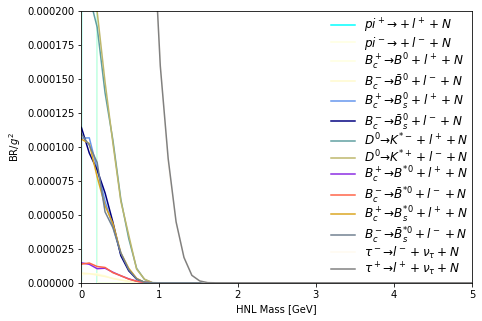

In [16]:
#I think this part should be moved to the productions part of the notebook? or maybe not since we need to set the model before plotting
start=0.0001
stop=10
masses=np.linspace(start, stop, num=100)

#production_channels is in a slightly wrong format, so edit it to be in a correct format
production_channels_fin=[]
for n in range(len(production_channels)):
    production_channels_fin.append(eval(production_channels[n])[0])

foresee.plot_production_branchings(
    masses = masses, 
    productions = production_channels_fin, #productions_2body
    xlims=[0,5],ylims=[0,.0002], 
    xlabel=r"HNL Mass [GeV]", 
    ylabel=r"BR/$g^2$",
    legendloc=(1.02,1.02),
    fs_label=12,log_scale=False, nsample=nsteps
)

Let's first look at one benchmark scenario with $M_{N}=1$ GeV and $\epsilon=10^{-3.5}$ using the function `foresee.get_llp_spectrum()`. By default, the result are saved in the `model/LLP_spectra` directory. However, here set `save_file=False` since we don't want to save the results but set `do_plot=True` to plot them. 

In [17]:
plot = foresee.get_llp_spectrum(mass=.1, coupling=10**(-3.5), do_plot=True, save_file=False)

KeyboardInterrupt: 

We can now produce a set of LLP spectra for various masses  (chosen to be equally spaced in log(mass)) and unit coupling and save them. 

In [ ]:
#removes br files, since this part will create them again
path="Users/alechewitt/Desktop/Git_felix_new/FORESEE/Models/HNL/model/LLP_spectra/*"
hnl.remove_files_from_folder(path)
masses = np.logspace(-1,1,20+1)
masses=list(masses)
masses.append(1)
for mass in masses:
    foresee.get_llp_spectrum(mass=mass,coupling=1)

## 4. Count Event Rate in Detector

Before counting the number of decays within the detector volume, let us specify the detector geometry. For this we need

- the `distance` from the IP in meter (default: 480)
- the `length` in meter (default: 5)
- the `luminosity` in units of fb^-1 (default: 3000)
- the `selection` depending in `x.x` and `x.y` (default: `np.sqrt(x.x**2 + x.y**2)< 1`)
- the decay `channels` which the detector can see (default: None, meaning all of them)

The default correspond to the FASER2 detector.

In [ ]:
distance, selection, length, luminosity, channels = 480, "np.sqrt(x.x**2 + x.y**2)< 1", 5, 3000, None
foresee.set_detector(distance=distance, selection=selection, length=length, luminosity=luminosity, channels=channels)

Let us look for one specific HNL mass $M_{N}=1$ GeV at how many particle decay inside the decay volume. This can be done using `get_events()` for which we need to specify again the mass and filename. Additionally, we can specify 

- the `couplings` for which we evaluate the event rate as numpy array (deault `np.logspace(-8,-3,51)`)
- the `preselectioncuts` when reading the LLP spectra in terms of momentum `p` and angle `th` (default: `th<0.01 and p>100`)
- the number `nsample` describing how many randomly choosen values of $\phi_{LLP}$ should sampled (default 1). This is only relevant for detectors that are not cylyndrical or not centered around the beam axis. 
- the production `modes` which should be considered
- the `energy` of the experiments

In [ ]:
#you must use one of the masses from the list 'masses' above that generated and saved the llp spectra in order to get nonzero signals
output = foresee.get_events(mass=1, energy=energy, couplings=np.logspace(-5,0,6))
coups, ctaus, nsigs, momenta, weights = output
for coup,ctau,nsig in zip(coups, ctaus, nsigs):
    print ("epsilon =", '{:5.3e}'.format(coup), ": nsignal =", '{:5.3e}'.format(nsig))

The previous function also outputs the energy distribution of the HNL particles which decay inside the detector. Let's have a look at them.

In [ ]:
from matplotlib import pyplot as plt
fig = plt.figure(figsize=(7,5))
ax = plt.subplot(1,1,1)
ens=[]
for coup,momentum,weight in zip(coups,momenta,weights):
    if sum(weight)<10**-3 : continue
    ax.hist([p.e for p in momentum],  weights=weight, bins=np.logspace(2,4, 20), histtype='step', label=r"$g=$"+str(coup)) 
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_ylim(10**-1,9*10**7) 
    ax.set_xlabel("E(N) [GeV]") 
    ax.set_ylabel("Number of Events per bin") 
    ax.legend(frameon=False, labelspacing=0)
plt.tight_layout()
plt.show()

FORESEE also includes a function `write_events()` which obtains an unweighted sample of LLP decay events and saves them as a HEPMC file. For this function, we need to specify
- the `mass` and `coupling` of the LLP
- the collision `energy`
- the number of events `numberevent` that should be samples (optional, default=10)
- the `filename` of the output file (optional, default=`model/events/<mass>_<coupling>.hepmc`)
- the z-position (in meter) of the beginning of the decay volume (optional, default=0)
- a random `seed` (optional, default=None)
- the `decaychannels` for which the event should bbe written to file (optional, default=None meaning that all channels are written to file)

At the moment, FORESEE only supports 2-body LLP decays. For all other cases, including those where no final state information was specified when initiating the `Model`, the LLP will not be decayed. 

In [ ]:
foresee.write_events(filename="model/events/test.hepmc", mass=1, coupling=1.000e-02, 
    energy="14", numberevent=10, zfront=0)

Let us have a look at a the output:

In [ ]:
f = open("model/events/test.hepmc", 'r')
file_contents = f.read()
print (file_contents)

## 5. Parameter Scan

In the following, we will get the LLP sensitivity reach for different detector configuraions. As an example, we show the FASER2 reach for dark photons for 3 scenarios. We just need to loop over different masses and use the previously introduced funtion `get_events`. The results will be written into a `.npy` file that we can store and plot later.

- the nominal/default setup

In [ ]:
#masses
masses = np.logspace(-1,1,20+1)

#specify setup
luminosity, distance = 3000 , 480
setup, selection, channels = "default", "np.sqrt(x.x**2 + x.y**2)< 1", None
foresee.set_detector(selection=selection, channels=channels, distance=distance, luminosity=luminosity)

#get reach 
list_nevents = []    
for mass in masses:
    couplings, _, nevents, _, _ = foresee.get_events(mass=mass, energy=energy,couplings=np.logspace(-5,0,50+1))
    list_nevents.append(nevents)  
    
#save results
np.save(model.modelpath+"model/results/"+energy+"TeV_"+setup+".npy",[masses,couplings,list_nevents])

## 6. Plot the Results

Now let's plot the results. We first specify all detector setups for which we want to show result (filename in model/results directory, label, color, linestyle, opacity alpha for filled contours, required number of events).

In [ ]:
setups = [
    ["14TeV_default.npy",    "default"  , "red",     "solid", 0., 3],
]

Then we specify all the existing bounds (filename in model/bounds directory, label, label position x, label position y, label rotation)

In [ ]:
bounds = bounds = [ 
    ["bounds_LHCb1.txt", "LHCb",  0.220, 0.9*10**-4, 0  ],
    ["bounds_LHCb2.txt",  None  , 0    , 0         , 0  ],
    ["bounds_LHCb3.txt",  None  , 0    , 0         , 0  ],
    ["bounds_E137.txt",  "E137",  0.015, 1.2*10**-7, 0  ],
    ["bounds_Charm.txt", "CHARM", 0.120, 1.3*10**-7, -8 ],
    ["bounds_NuCal.txt", "NuCal", 0.041, 8.0*10**-6, -24],
    ["bounds_E141.txt",  "E141",  0.011, 7.5*10**-5, 17 ],
    ["bounds_NA64.txt",  "NA64",  0.013, 2.3*10**-4, -35],
    ["bounds_BaBar.txt", "BaBar", 0.360, 1.4*10**-3, 0  ],
    ["bounds_NA48.txt",  "NA48",  0.040, 1.4*10**-3, 0  ],
]


#more correct than above
bounds = [ 
    ["bounds_BBN_el.txt",  "BBN"  , 3*10**-1    , 3*10**-5        , -40  ],
    ["bounds_el.txt",None,  0.220, 0.9*10**-4, 0  ],
    ]

'''["bounds_LHCb_el.txt",  "LHCb"  , 0    , 0         , 0  ]
    ["bounds_el.txt", None,  0.220, 0.9*10**-4, 0  ],
'''

#this one doesnt even show up
#["bounds_LHCb_el.txt",  None  , 0    , 0         , 0  ]

We then specify other projected sensitivitities (filename in model/bounds directory, color, label, label position x, label position y, label rotation)

In [ ]:
projections = [




    ["limits_SHiP_el.txt",           "orange",  "SHiP"    , 3, 10**-4, 0  ],
    ["limits_NA62_el.txt",           "blue",    "NA62"    ,1, 0.0002 , 0  ],
    ["limits_DUNE_el.txt",           "magenta",    "DUNE"    ,0.6, 0.00009 , 0  ],
    ['limits_CODEX_el.txt',           "purple",    "CODEX"    ,2*10**-1, 0.0003, 0  ],
    ["limits_MATHUSLA_el.txt",           "forestgreen",  "MATHUSLA"    , 0.3, 0.0001 , 0  ]



]

Finally, we can plot everything using `foresee.plot_reach()`. It returns a matplotlib instance, to which we can add further lines and which we can show or save. Below, we add the dark matter relict target line for a specific benchmark.

In [ ]:
plot = foresee.plot_reach(
    setups=setups,
    bounds=bounds,
    projections=projections,
    title="HNL with Electron Couplings",
    xlims = [1e-1, 10], 
    ylims = [1e-5, 10e-2 ],
    xlabel=r"HNL mass $M_{N}$ [GeV]", 
    ylabel=r"Kinetic Mixing $|U_{e}|$",
    legendloc=(1,0.68),
    figsize=(8,6),
)
plot.subplots_adjust(left=0.12, right=0.97, bottom=0.10, top=0.95)
#plot.savefig("/Users/alechewitt/Desktop/Figure.pdf")
plot.show()

$\color{red}{\text{      ... THE OLD (MAGENTA) and NEW (RED) LINES LOOK SIMILAR}}$
$\color{red}{\text{      ... THE DIFFERENCED RE PROABLY DUE TO DIFFERENT CHARM PRODUCTION AND MISSING PROD. CHANNELS}}$

## 7. Export Contours

It might also be useful to extract the contours lines, and save them as a text file. This can be done using the `extract_contours()` function. As example, let us export the FASER2 line. 

In [ ]:
foresee.extract_contours(
    inputfile="model/results/14TeV_default.npy", 
    outputfile="model/lines/limits_FASER2.txt"
)

## Plot Production Cross Section 

We also can plot the production cross section as a function of the particle mass via `foresee.plot_production`. We do this below to show the production rate associated with different channels (commenting out the subleading channels): 

In [ ]:
masses = [0.1, 0.2, 0.3, 0.7, 1, 1.2, 1.4, 2, 3 ]
productions = [
    ["2body_411_-11"     , None      , "firebrick"   , r"$D^+ \to e^+ N$"   ],   
    ["2body_431_-11"     , None      , "red"         , r"$D_s^+ \to e^+ N$" ],   
    ["2body_521_-11"     , [0.5,10]  , "orange"      , r"$B^+ \to e^+ N$"   ],  
    ["2body_541_-11"     , [0.5,10]  , "gold"        , r"$B_c^+ \to e^+ N$" ],   
    ["3body_411_-311_-11", None      , "blue"        , r"$D^+ \to \bar{K}^0 e^+ N$" ],   
    ["3body_421_-321_-11", None      , "deepskyblue" , r"$D^0 \to K^- e^+ N$"       ], 
    ["3body_511_-411_-11", [0.5,10]  , "green"       , r"$B^0 \to D^- e^+ N$"       ], 
    ["3body_531_-431_-11", [0.5,10]  , "limegreen"   , r"$B_s^+ \to D_s^- e^+ N$"   ], 
]

foresee.plot_production(
    masses = masses, 
    productions = productions,
    condition="True", 
    xlims=[0.1,30],ylims=[10**0,10**10], 
    xlabel=r"HNL Mass [GeV]", 
    ylabel=r"Production Rate $\sigma/\epsilon^2$ [pb]",
    legendloc=(1.02,1.02),
    fs_label=12,
    title="All HNLs",
)

plot.savefig("Figure_HNL_Prod_All.pdf")
plot.show()